# Load SSP Grid

In [1]:
# NBVAL_SKIP
from rubix.spectra.ssp.templates import BruzualCharlot2003

print(BruzualCharlot2003)


2024-07-16 11:49:14,690 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <  
/_/|_|\____/____/___/_/|_|  
                            

2024-07-16 11:49:14,691 - rubix - INFO - Rubix version: 0.0.post66+g42d5801.d20240712
2024-07-16 11:49:14,693 - rubix - WARNING - python-fsps is not installed. Please install it to use this function. Install using pip install fsps and check the installation page: https://dfm.io/python-fsps/current/installation/ for more details. Especially, make sure to set all necessary environment variables.


HDF5SSPGrid(age=Array([ 0.       ,  5.100002 ,  5.1500006,  5.1999993,  5.25     ,
        5.3000016,  5.350002 ,  5.4000006,  5.4500012,  5.500002 ,
        5.550002 ,  5.600002 ,  5.6500025,  5.700002 ,  5.750002 ,
        5.8000026,  5.850003 ,  5.900003 ,  5.950003 ,  6.       ,
        6.0200005,  6.040001 ,  6.0599985,  6.0799985,  6.100002 ,
        6.120001 ,  6.1399984,  6.16     ,  6.18     ,  6.1999993,
        6.2200007,  6.24     ,  6.2599998,  6.2799997,  6.2999997,
        6.3199987,  6.3399997,  6.3600006,  6.3799996,  6.3999987,
        6.4200006,  6.44     ,  6.4599996,  6.4799995,  6.499999 ,
        6.52     ,  6.539999 ,  6.56     ,  6.5799994,  6.6      ,
        6.6199994,  6.6399994,  6.66     ,  6.679999 ,  6.699999 ,
        6.72     ,  6.7399993,  6.7599993,  6.7799997,  6.799999 ,
        6.819999 ,  6.839999 ,  6.8599997,  6.879999 ,  6.899999 ,
        6.919999 ,  6.939999 ,  6.959999 ,  6.9799986,  6.999999 ,
        7.0200005,  7.040001 ,  7.0599985,  7.

SSP lookup

2.550001


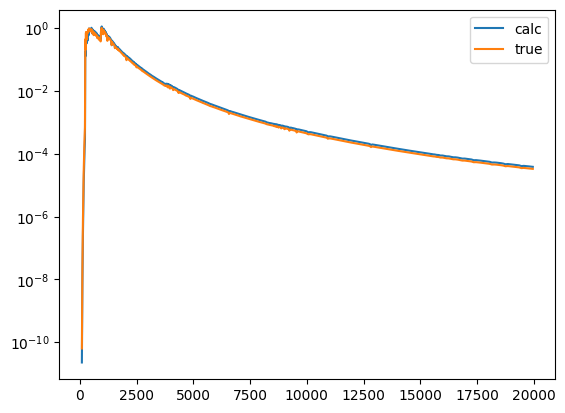

In [2]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
from rubix.spectra.ssp.templates import BruzualCharlot2003
from jax import jit

ssp = BruzualCharlot2003
wave = ssp.wavelength


age_index = 0
met_index = 3

target_age = ssp.age[age_index] + 0.5*(ssp.age[age_index+1] - ssp.age[age_index])
print(target_age)
target_met = ssp.metallicity[met_index] + 0.5*(ssp.metallicity[met_index+1] - ssp.metallicity[met_index])

lookup = ssp.get_lookup_interpolation()

spec_calc = lookup(target_met, target_age)

spec_true = ssp.flux[met_index, age_index, :]

plt.plot(wave, spec_calc, label='calc')
plt.plot(wave, spec_true, label='true')

plt.legend()
plt.yscale('log')

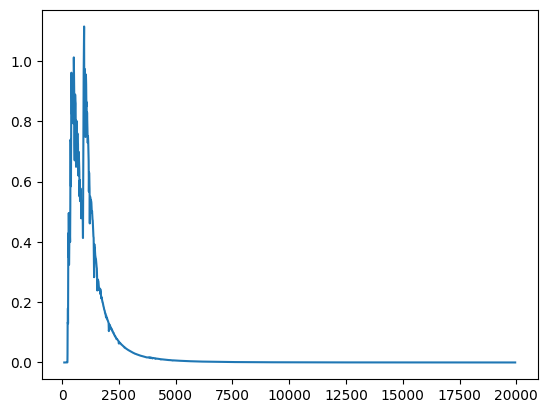

In [3]:
# NBVAL_SKIP
# Check if it works with jit

spec_calc = jit(lookup)(target_met, target_age)

plt.plot(wave, spec_calc, label='calc jit')

In [4]:
# NBVAL_SKIP
from rubix.utils import load_galaxy_data

data, units = load_galaxy_data("output/rubix_galaxy.h5")
mass = data["particle_data"]["stars"]["mass"]
metallicity = data["particle_data"]["stars"]["metallicity"]
age = data["particle_data"]["stars"]["age"]

Vmap

In [5]:
# NBVAL_SKIP
# Calculate spectra with vmap
from jax import vmap

lookup = ssp.get_lookup_interpolation()

subset = 1000

# Use only subset because it is too big to fit into gpu memory
met_subset = metallicity[:subset]
age_subset = age[:subset]


# Clip the metallicity and age values to the range of the SSP

met_subset = met_subset.clip(min(ssp.metallicity), max(ssp.metallicity))
age_subset = age_subset.clip(min(ssp.age), max(ssp.age))


spec_calc = vmap(lookup)(met_subset, age_subset)


spec_calc.shape


(1000, 842)

In [7]:
# NBVAL_SKIP
# check if it contains nan values
import jax.numpy as jnp
jnp.isnan(spec_calc).any()

Array(False, dtype=bool)

# Use configuration to load lookup function

In [8]:
config ={ "ssp": {
    "template": {
      "name": "BruzualCharlot2003"
    },
    "method": "cubic"
  }
}

In [9]:
# NBVAL_SKIP
from rubix.core.ssp import get_lookup_interpolation

lookup = get_lookup_interpolation(config)

2024-07-16 11:50:06,731 - rubix - DEBUG - Using method defined in config: cubic


In [10]:
# NBVAL_SKIP
# Check how many particles are outside the range of the SSP
import numpy as np
np.sum(metallicity < ssp.metallicity[0]), np.sum(metallicity > ssp.metallicity[-1])

(Array(765, dtype=int32), Array(52295, dtype=int32))

In [11]:
# NBVAL_SKIP
np.sum(age < ssp.age[0]), np.sum(age > ssp.age[-1])

(Array(0, dtype=int32), Array(112209, dtype=int32))

In [12]:
# NBVAL_SKIP
len(metallicity)

649384

In [13]:
# NBVAL_SKIP
# clip the metallicity and age values to the range of the SSP
met_subset = met_subset.clip(min(ssp.metallicity), max(ssp.metallicity))
age_subset = age_subset.clip(min(ssp.age), max(ssp.age))
lookup(met_subset, age_subset)

Array([[ 1.6269833e-04,  2.1775998e-04,  2.6080012e-04, ...,
         2.7193467e-04,  2.6691900e-04,  2.6253317e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.3473026e-04,  3.2869022e-04,  3.2401134e-04],
       [ 6.7457506e-05,  9.8355034e-05,  1.2561669e-04, ...,
         7.3448784e-04,  7.2058832e-04,  7.0978311e-04],
       ...,
       [-2.7331212e-03, -2.8226445e-03, -2.8494801e-03, ...,
         3.3740103e-04,  3.3112825e-04,  3.2580519e-04],
       [ 4.2508356e-05,  6.2172767e-05,  7.9579884e-05, ...,
         1.3732283e-03,  1.3470872e-03,  1.3274353e-03],
       [-5.4081436e-03, -5.6985402e-03, -5.8084256e-03, ...,
         2.3222195e-04,  2.2796373e-04,  2.2408615e-04]], dtype=float32)